In [1]:
import cv2
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d
%matplotlib inline

## ICP Algorithm Development

In [2]:
im0 = plt.imread('RGB-data/scene_01/00000-color.png')
im0d = plt.imread('RGB-data/scene_01/00000-depth.png')

im1 = plt.imread('RGB-data/scene_01/00020-color.png')
im1d = plt.imread('RGB-data/scene_01/00020-depth.png')

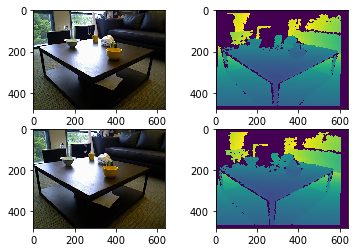

In [3]:
plt.subplot(2,2,1)
plt.imshow(im0)
plt.subplot(2,2,2)
plt.imshow(im0d)
plt.subplot(2,2,3)
plt.imshow(im1)
plt.subplot(2,2,4)
plt.imshow(im1d)
plt.show()

In [4]:
def triangulate(depth_map, fx = 5, fy = 5):
    h,w = depth_map.shape
    xx,yy = np.meshgrid(np.arange(w), np.arange(h))
    mask = (depth_map > 0)
    
    proj_x = (xx[mask] - w/2) * depth_map[mask] / fx
    proj_y = (yy[mask] - h/2) * depth_map[mask] / fy
    
    return np.vstack((proj_x.flatten(), proj_y.flatten(), depth_map[mask].flatten())), mask

In [5]:
def visual(R,t,ax):
    x = np.array([[1,0,0,1]]).T
    y = np.array([[0,1,0,1]]).T
    z = np.array([[0,0,1,1]]).T
    ze = np.array([[0,0,0,1]]).T
    
    transform = np.hstack((R,t))
    
    xt = transform @ x
    yt = transform @ y
    zt = transform @ z
    zet = transform @ ze
    
    vecA = xt - zet
    vecB = yt - zet
    vecC = zt - zet
    assert (vecA.T @ vecB)[0] <1e-5, f'nonzero dot {(vecA.T @ vecB)[0]}'
    assert (vecA.T @ vecC)[0] <1e-5, f'nonzero dot {(vecA.T @ vecC)[0]}'
    assert (vecB.T @ vecC)[0] <1e-5, f'nonzero dot {(vecB.T @ vecC)[0]}'
    
    pts = np.hstack((xt,yt,zt,zet))
    ax.scatter(pts[0,:], pts[1,:], pts[2,:])
    xvec = np.hstack((zet,xt))
    yvec = np.hstack((zet,yt))
    zvec = np.hstack((zet,zt))
    ax.plot(xvec[0,:], xvec[1,:], xvec[2,:],c='blue')
    ax.plot(yvec[0,:], yvec[1,:], yvec[2,:],c='red')
    ax.plot(zvec[0,:], zvec[1,:], zvec[2,:],c='green')

In [6]:
def create_output(vertices, colors, filename):
	vertices = np.hstack([vertices,colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

## All 8 point Stuf

In [7]:
im0_ = plt.imread('RGB-data/scene_01/00000-color.png')
im0d_ = plt.imread('RGB-data/scene_01/00000-depth.png')

im1_ = plt.imread('RGB-data/scene_01/00020-color.png')
im1d_ = plt.imread('RGB-data/scene_01/00020-depth.png')

im2_ = plt.imread('RGB-data/scene_01/00040-color.png')
im2d_ = plt.imread('RGB-data/scene_01/00040-depth.png')

In [8]:
from eightPoint import motion8

In [9]:
h,w = im0d_.shape
K = np.array([[500,0,w/2],
              [0,500,h/2],
              [0,0,1]])

In [10]:
R = np.eye(3)
t = np.array([[0,0,0]]).T

R0, t0 = motion8(im0_,im1_,K)
R1,t1 = motion8(im1_,im2_,K)

R = R0 @ R
t = t0 + t

R = R1 @ R
t=  t1 + t

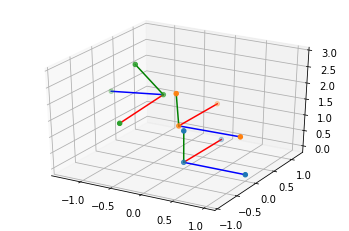

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

visual(np.eye(3), np.array([[0,0,0]]).T, ax)
visual(R0,t0,ax)
visual(R,t,ax)

plt.show()

In [12]:
pts3_0,mask0 = triangulate(im0d_, fx=500, fy=500)
pts3_1,mask1 = triangulate(im1d_, fx=500, fy=500)
pts3_2,mask2 = triangulate(im2d_, fx=500, fy=500)

pts3_1 = (R0@pts3_1) + t0

In [13]:
color_map0 = np.uint8(im0*255)[mask0].reshape(-1,3)
color_map1 = np.uint8(im1*255)[mask1].reshape(-1,3)
color_map = np.vstack( (color_map0,color_map1) )
pts3 = np.hstack( (pts3_0, pts3_1) )

create_output(pts3.T,color_map,'BeforeICP_8point.ply')

## ICP

In [14]:
im0 = plt.imread('RGB-data/scene_01/00060-color.png')
im0d = plt.imread('RGB-data/scene_01/00060-depth.png')

im1 = plt.imread('RGB-data/scene_01/00080-color.png')
im1d = plt.imread('RGB-data/scene_01/00080-depth.png')

im2 = plt.imread('RGB-data/scene_01/00100-color.png')
im2d = plt.imread('RGB-data/scene_01/00100-depth.png')

im3 = plt.imread('RGB-data/scene_01/00120-color.png')
im3d = plt.imread('RGB-data/scene_01/00120-depth.png')

im4 = plt.imread('RGB-data/scene_01/00140-color.png')
im4d = plt.imread('RGB-data/scene_01/00140-depth.png')

im5 = plt.imread('RGB-data/scene_01/00160-color.png')
im5d = plt.imread('RGB-data/scene_01/00160-depth.png')

im6 = plt.imread('RGB-data/scene_01/00180-color.png')
im6d = plt.imread('RGB-data/scene_01/00180-depth.png')

In [15]:
pts3_0,mask0 = triangulate(im0d, fx=500, fy=500)
pts3_1,mask1 = triangulate(im1d, fx=500, fy=500)
pts3_2,mask2 = triangulate(im2d, fx=500, fy=500)
pts3_3,mask3 = triangulate(im3d, fx=500, fy=500)
pts3_4,mask4 = triangulate(im4d, fx=500, fy=500)
pts3_5,mask5 = triangulate(im5d, fx=500, fy=500)
pts3_6,mask6 = triangulate(im6d, fx=500, fy=500)

In [16]:
from scipy.spatial import KDTree

In [17]:
def icp_svd(pts3_src, pts3_dst, iter_=1):
    kd_tree = KDTree(pts3_dst.T)
    
    R_total = np.eye(3)
    t_total = np.array([[0,0,0]]).T
    for i in range(iter_):
        _, corr = kd_tree.query(pts3_src.T)
        pts3_src_corr = pts3_dst[:,corr]

        pts3_src_corr_mu0 = pts3_src_corr - np.mean(pts3_src_corr,axis=1).reshape(3,1)
        pts3_src_mu0 = pts3_src - np.mean(pts3_src,axis=1).reshape(3,1)

        cross_corr = pts3_src_corr_mu0 @ pts3_src_mu0.T
        U,S,VT = np.linalg.svd(cross_corr)
        R = U @ VT
        t = np.mean(pts3_src_corr,axis=1).reshape(3,1) - R @ (np.mean(pts3_src,axis=1).reshape(3,1))
        pts3_src = R @ pts3_src + t
        
        R_total = R @ R_total
        t_total = R@t_total + t
    print('Done')
    return pts3_src, R_total, t_total

In [18]:
pts3_src = pts3_0.copy()
pts3_dst = pts3_1.copy()
t_pts3_src0, R0, t0 = icp_svd(pts3_src, pts3_dst, iter_=10)

Done


In [19]:
pts3_src = pts3_1.copy()
pts3_dst = pts3_2.copy()
t_pts3_src1, R1, t1 = icp_svd(pts3_src, pts3_dst, iter_=40)
t_pts3_src0 = R1 @ t_pts3_src0 + t1

Done


In [20]:
pts3_src = pts3_2.copy()
pts3_dst = pts3_3.copy()
t_pts3_src2, R2, t2 = icp_svd(pts3_src, pts3_dst, iter_=40)
t_pts3_src0 = R2 @ t_pts3_src0 + t2
t_pts3_src1 = R2 @ t_pts3_src1 + t2

Done


In [240]:
pts3_src = pts3_3.copy()
pts3_dst = pts3_4.copy()

t_pts3_src3, R3, t3 = icp_svd(pts3_src, pts3_dst, iter_=20)

t_pts3_src0 = R3 @ t_pts3_src0 + t3
t_pts3_src1 = R3 @ t_pts3_src1 + t3
t_pts3_src2 = R3 @ t_pts3_src2 + t3


pts3_src = pts3_4.copy()
pts3_dst = pts3_5.copy()

t_pts3_src4, R4, t4 = icp_svd(pts3_src, pts3_dst, iter_=20)
t_pts3_src0 = R4 @ t_pts3_src0 + t4
t_pts3_src1 = R4 @ t_pts3_src1 + t4
t_pts3_src2 = R4 @ t_pts3_src2 + t4
t_pts3_src3 = R4 @ t_pts3_src3 + t4

pts3_src = pts3_5.copy()
pts3_dst = pts3_6.copy()

t_pts3_src5, R5, t5 = icp_svd(pts3_src, pts3_dst, iter_=10)
t_pts3_src0 = R5 @ t_pts3_src0 + t5
t_pts3_src1 = R5 @ t_pts3_src1 + t5
t_pts3_src2 = R5 @ t_pts3_src2 + t5
t_pts3_src3 = R5 @ t_pts3_src3 + t5
t_pts3_src4 = R5 @ t_pts3_src4 + t5

Done
Done
Done


In [243]:
color_map0 = np.uint8(im0*255)[mask0].reshape(-1,3)
color_map1 = np.uint8(im1*255)[mask1].reshape(-1,3)
color_map2 = np.uint8(im2*255)[mask2].reshape(-1,3)
color_map3 = np.uint8(im3*255)[mask3].reshape(-1,3)
color_map4 = np.uint8(im4*255)[mask4].reshape(-1,3)
color_map5 = np.uint8(im5*255)[mask5].reshape(-1,3)
color_map6 = np.uint8(im6*255)[mask6].reshape(-1,3)


In [21]:
color_map = np.vstack( (color_map0,color_map1,color_map2,color_map3) )
pts3 = np.hstack( (t_pts3_src0, t_pts3_src1, t_pts3_src2, pts3_3) )

create_output(pts3.T,color_map,'AfterICP.ply')

NameError: name 'color_map2' is not defined

In [ ]:
color_map = np.vstack( (color_map0,color_map1,color_map2,color_map3,color_map4,color_map5,color_map6) )
pts3 = np.hstack( (t_pts3_src0, t_pts3_src1, t_pts3_src2, t_pts3_src3,t_pts3_src4,t_pts3_src5,pts3_6) )

create_output(pts3.T,color_map,'AfterICP.ply')